# Wildfire Threat Detection for Transportation Infrastructure using U-Net for Semantic Segmentation

Wildfires have increasingly been studied for their risks to forest cover, housing, and critical infrastructure such as power and water systems, as well as their effects on air quality, water quality, erosion, and public health. However, wildfires can also cause short and long-term disruptions to transportation systems – a critical yet often overlooked area of impact. 

This U-Net model uses aerial imagery and wildfire threat labels applied along transportation infrastructure (roads and railways) to learn different levels of wildfire risk along transportation infrastructure. Once trained, the model can analyze new images and predict wildfire risk levels at the pixel scale, identifying which roads and rail segments may be at risk from fire-related impacts.  

We designed this tool to have broad applicability. 
- As an emergency response coordinator or transportation analyst, this tool may support proactive evacuation or rerouting decisions. 
- As an urban or regional planner, this tool may help incorporate wildfire risk into land use and infrastructure decision. 
- As a Geographic Information Systems (GIS) specialist, this tool may support integrating model outputs into maps, dashboards, or other near real-time platforms. 

**This notebook provides a guide to utilizing [CAL FIRE](https://www.fire.ca.gov/what-we-do/fire-resource-assessment-program/gis-mapping-and-data-analytics) (California Department of Forestry and Fire Protection) GIS data, transportation infrastructure GIS data, and high-resolution Sentinel-2 imagery for wildfire threat segmentation tasks using a U-Net deep learning model.**

<div style="display: flex; justify-content: space-around; margin-bottom: 20px;">
  <figure id="flow-diagram" style="margin: 0 10px;">
    <img src="resources/flow_diagram.png"
    alt="Flow diagram that illustrates how data is used to predict and depict wildfire threat along transportation infrastrcuture."
    width="500"/>
    <figcaption>Data flow for wildfire threat detection to infrastructure using U-Net</figcaption>
  </figure>
</div>



## Overview
This notebook is the entry point for this project. This notebook, if all cells are run will install and import the necessary packages, including two additional ipynb:  [`utils.ipynb`](utils.ipynb) and [`unet.ipynb`](unet.ipynb). This notebook will then load the data, display a sample of it, and the preprocess it for training a U-Net image segmentation model. This notebook will then set-up create, and train the U-Net model. Finally the training results and model performance are available, along with the ability to save output data. **Throughout the notebook there are additional sections explaining the motivations, the tools, and the results, in the context of wildifre threat detection. **

## Outline
- **[Setup and Import Necessary Packages](#setup-and-import-necessary-packages)**: Install and import the libraries and packages needed for the project.

- **[Input File Directories, Load Data, and View a Sample of Data](#input-file-directories-load-data-and-view-a-sample-of-data)**: Load images and masks form the given directories, and view a sample of that data for verification.

- **[Configure and Preprocess Data](#configure-and-preprocess-data)**: Configure and prepare the data for the U-Net. Includes an explanation of [Class remapping](#value-of-mask-class-remapping).

- **[Build and Train the U-Net Model](#build-and-train-the-u-net-model)**: Configure, build, and train the U-Net. Includes an [explanation of the U-Net](#u-net-background) and [our specific architecture](#unique-features-of-our-u-net-model).

- **[Model Evaluation](#model-evaluation)**: Evaluate the model and save the predictions if desired. Includes analyses of [training results](#training-results), [prediction results](#prediction-results), the [importance of risk prediction](#importance-of-risk-predictions-for-transportation-corridors), and a [comparison with CAL FIRE classes](#comparison-with-cal-fire-classes).

- **[Conclusions](#conclusions)**: Concludes this work and present final analyses. 

- **[References](#references)**: References used in this notebook, and additional references used throughout our I-GUIDE elements.

### Usage
This notebook assumes that the helper functions [`utils.ipynb`](utils.ipynb), and the U-Net model functions [`unet.ipynb`](unet.ipynb) are imported correctly. 

There are several code blocks that are fully commented out. These code blocks may take a significant amount of time to run, and are included for reference. They should not necessarily be run here. 

If you choose to uncomment those code blocks and run the model, You may be able to use the following information to approximate the run-time, with the default parameters:

#### Software Environment
- [**Python 3.11.9**](https://www.python.org/downloads/release/python-3119/), **No GPU**
- [**Jupyter Notebook 7.3.3**](https://jupyter.org/)

#### Hardware
- **CPU**: Intel Core i7-1370P
- **RAM**: 32 GB
- **Storage**: 450 GB NVMe SSD
- **Operating System**: Microsoft Windows 11 Enterprise

#### Runtimes:
- approximately 750s (12.5 mins) per epoch
- All other code cells were less than 60s (1 min)
    - If the necessary libraries are not already installed, then `%pip` install will take significantly longer than 1 minute, with libraries like TensorFlow taking several minutes. 

## Setup and Import Necessary Packages

In the following three code cells, we will set up our environment by installing the necessary packages and importing the required libraries, and then optionally setting our model for "production" or "testing". This setup includes custom utility functions, a U-Net model implementation, and setting the random seed.

### Step 1: Install Required Packages

First, we will use the `%pip` magic command to install the necessary packages from a [`requirements.txt`](requirements.txt) file. This ensures that all dependencies are installed before we proceed with importing them.

If you don't have the [`requirements.txt`](requirements.txt) file, you can find it [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). You can also find a detailed list of the key libraries in the [README](README.md). THey are included below for convenience:
#### Development Environment
- [**Python 3.11.x**](https://www.python.org/downloads/release/python-3119/)
- [**Jupyter Notebook**](https://jupyter.org/)

#### Standard library imports
- [**os**](https://docs.python.org/3/library/os.html)\*: Provides a way of using operating system-dependent functionality.
- [**sys**](https://docs.python.org/3/library/sys.html)\*: Provides access to some variables used or maintained by the Python interpreter.
- [**pathlib**](https://docs.python.org/3/library/pathlib.html)\* : Object-oriented filesystem paths.
- [**warnings**](https://docs.python.org/3/library/warnings.html)\*: Provides a way to issue warning messages.
- [**import_ipynb**](https://pypi.org/project/import-ipynb/): Allows importing Jupyter Notebooks as modules.

#### Third-party libraries
- [**NumPy 2.1.x**](https://numpy.org/): Numerical computing with arrays and matrices.
- [**TensorFlow 2.19.x**](https://www.tensorflow.org/): Machine learning and AI platform.
- [**Matplotlib 3.10.x**](https://matplotlib.org/): Plotting and visualization library.
- [**Scikit-Learn 1.6.x**](https://scikit-learn.org/): Machine learning tools for data analysis.
- [**PIL (Pillow) 11.1.x**](https://pillow.readthedocs.io/en/stable/index.html): Image processing library.

**Note:** These key libraries and dependencies will install additional dependencies that they may need, when installed. The [`requirements.txt`](requirements.txt) contains the full list of dependencies, some of which may not be directly used in this project. 

\* These are standard built-in Python (3.4 or higher) libraries that **do not** need to be installed separately. 

In [19]:
# Installing the necessary packages
# Suppress already satisfied warning using: | find /V "already satisfied"
%pip install -r requirements.txt | find /V "already satisfied"

Note: you may need to restart the kernel to use updated packages.


### Step 2: Import Necessary Packages

Next, we will import the necessary packages and libraries for our project. This includes:

- Standard libraries and packages
- Custom utility functions from `utils.py`
- U-Net model implementation and associated functions from `unet.py`

These custom files contain functions that will be used throughout this notebook.

In [20]:
# Standard library imports
import os                          # For interacting with the operating system
from pathlib import Path           # For handling file system paths
import warnings                    # For managing warnings
import import_ipynb                # For importing Jupyter notebooks as modules

# Third-party library imports
import matplotlib.pyplot as plt    # For plotting graphs and images
import numpy as np                 # For numerical operations
from sklearn.model_selection import train_test_split  # For splitting datasets into training and testing sets


# Custom utility functions
from utils import (
    load_images_and_masks,         # Function to load images and masks
    view_data,                     # Function to visualize data
    preprocess_images_and_masks,   # Function to preprocess images and masks
    remap_mask_classes,            # Function to remap mask classes
    save_datasets,                 # Function to save presplit datasets
    load_datasets,                 # Function to load presplit datasets
    save_associated_files,         # Function to save associated files
    custom_warnings,               # Function to format custom warnings
)

# Custom U-Net related functions
from unet import (
    unet_model,                    # Function to create the U-Net model
    test_unet,                     # Function to test the U-Net model
    plot_losses,                   # Function to plot training losses
    save_predicted_masks,          # Function to save predicted masks
    iou_metric,                    # Function to calculate Intersection over Union
    dice_coeff,                    # Function to calculate Dice coefficient
)

# Optional line to suppress TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# TensorFlow and Keras imports
from tensorflow.keras import callbacks, optimizers  # For handling callbacks and optimizers in Keras
import tensorflow as tf                             # TensorFlow library

# Force the warnings library to use the custom warnings format
warnings.formatwarning = custom_warnings

### Step 3: Setting to Production or Testing

Finally for setup we can set our model to be in testing mode (`PRODUCTION = False`) or production mode (`PRODUCTION = True`). 

In testing mode, this will keep the random seed the same across all the necessary libraries and packages, so that the code will have consistently reproducible results. 

In [21]:
# Force all seed values to be the same. This should only be done when testing.
PRODUCTION = False  # Flag to indicate whether the environment is production or not

# Seed value for reproducibility
seed_value = 42

# If not in production, set the seed values to ensure reproducibility
if not PRODUCTION:
    np.random.seed(seed_value) # Set the seed for NumPy's random number generator
    tf.random.set_seed(seed_value) # Set the seed for TensorFlow's random number generator
    os.environ["PYTHONHASHSEED"] = str(seed_value) # Set the seed for Python's built-in hash function    

## Input File Directories, Load Data, and View a Sample of Data

In the following three code cells, we will specify the file directories for images, masks, and model, and then load the data from these directories using a custom function. As a check that the data has been loaded correctly, we then view a small sample of the data.

### Step 4: Specify File Directories

First, we need to input the file directories where our images, masks, and models are stored. These directories will be used to load the data required for training and evaluation. These directories should all be relative file paths to the current working directory. 

In [22]:
# Set the necessary directories. These should be relative to the working directory
images_dir = "Datasets/Pala_Mesa_Roads_Rails/images"  # Directory for images
masks_dir = "Datasets/Pala_Mesa_Roads_Rails/labels"  # Directory for masks
model_dir = "models"  # Directory for saving the model
model_name = "trained_UNet_Pala_Mesa.keras"  # Model file name
model_path = Path(f"{model_dir}/{model_name}")  # Full path to the model file as a Path object

### Step 5: Load the Images and Masks

The next code cell loads the images and masks using a custom function defined in [`utils.ipynb`](utils.ipynb). You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). 

We have set the optional settings such as:
- `file_ext`: specifying the file extension type of our data
- `max_count`: the maximum number of images we would like to load in for our model
- `trim_names`: an additional feature that attempts to trim the filenames if they are of a format with characters and underscores preceding a large number of digits. More details can be found in the [`utils.ipynb`](utils.ipynb) under the `load_images_and_masks` function. 

In [23]:
# Load the images and masks
images, masks, missing_masks, names_map = load_images_and_masks(
    images_dir,          # Directory containing the images
    masks_dir,           # Directory containing the masks
    file_ext="tif",      # File extension of the images and masks
    max_count=1000,      # Maximum number of images and masks to load
    trim_names=True      # Whether to trim the names of the files
)

### Step 6: View a Sample of Data

The next code cell lets us view a sample of our images and masks, to make sure that they have loaded as expected. Again this is a custom function that can be found in [`utils.ipynb`](utils.ipynb). You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).

We have set the optional settings such as:
- `max_plots`: specifying the number of images (and masks) to plot
- `max_cols`: specifying the number of columns to use for display
- `randomize`: specifying to use a random subset of the loaded images (and their corresponding masks)
- `colors`: displaying the images and masks in color (as opposed to greyscale)

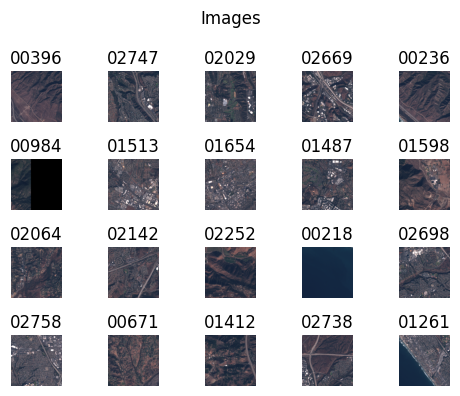

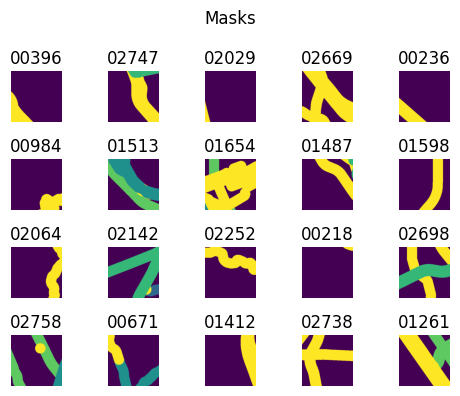

In [24]:
# View images and masks
view_data(
    images=images,       # List of images to view
    masks=masks,         # List of masks to view
    max_plots=20,        # Maximum number of plots to display
    max_cols=5,          # Maximum number of columns in the plot grid
    randomize=True,      # Whether to randomize the order of the images and masks
    colors=True          # Whether to display the masks in color
)

## Configure and Preprocess Data

In the following three code cells, we will prepare our data for the U-Net mode. We will optionally remap classes, preprocess the data, and split it into training, validation, and test sets.

### Value of Mask Class Remapping
One of the unique features of our approach is the option to remap the mask classes to a subset of the original mask classes. We included this feature for several reasons.

- **Handling Different Dataset Mappings**: We wanted to accommodate use cases where classes from different datasets had been mapped differently, but the risk calculation process remained the same. For example, if one dataset had 5 risk levels and another had 4, we could remap the 5 risk levels to 4 and use the same model.

- **Simplifying Risk Identification**: We also considered scenarios where the primary objective was to identify infrastructure or transportation corridors at risk, regardless of the specific risk level.

#### Challenges and Solutions:

During initial training, we faced challenges with long run times and large datasets, models, and data files. One contributing factor was the nature of one-hot encoding used in image segmentation tasks.

**One-Hot Encoding**: For each class, an additional fourth dimension value is added. For example, a mask with 5 channels for a 256x256 pixel image results in a mask size of 1x256x256x5. A batch of 1000 images would be 1000x256x256x5. This can lead to very large datasets, slowing down processes like loading, saving, modifying, and training the data.

To address this, we can consider remapping to a smaller subset of mask classes if the dataset becomes too unwieldy. For instance, distinguishing between background (no risk) and any transportation infrastructure at risk (single risk level) can be valuable. In this case, the data is treated as binary, reducing the dataset size from 1000x256x256x5 to 1000x256x256x1.

### Step 7: Optionally Remap the Mask Classes

You can optionally remap the mask classes down to a subset of the mask classes. This is done using a custom function that can be found in [`utils.ipynb`](utils.ipynb). You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). 

An important feature of the `remap_mask_classes` function: There are instances where, if it finds some discrepancies in the inputs, it will ask the user what they would like to do. Please follow the prompts accordingly.

We have set `REMAP_CLASSES = False`. If we chose to set it to `True`, then the `class_mapping` would map the old class index values to the new class index values. In the example, this maps old values `0,1,2,3` to new values `0,1`. We have also implemented the custom `view_data` function shown previously in [Step 6](#step-6-view-a-sample-of-data). Notice that in this case, only the masks were provided, since the images will remain unchanged. Please also note that the function outputs not only the new masks but the `num_classes` which can be used as an input in [Step 8](#step-8-preprocess-the-data)

In [25]:
# Optional remapping of classes
REMAP_CLASSES = False  # Flag to indicate whether to remap classes
class_mapping = {0: 0, 1: 1, 2: 1, 3: 1}  # Dictionary mapping old classes to new classes
if REMAP_CLASSES:
    masks, num_classes = remap_mask_classes(masks, class_mapping)  # Remap the classes in the masks
    view_data(masks=masks, max_plots=20, max_cols=5, randomize=False, colors=True)  # View the remapped masks

### Step 8: Preprocess the Data

Next, we need to ensure that the data is in the correct format for the U-Net. This is done using the custom function `preprocess_images_and_masks` that can be found in [`utils.ipynb`](utils.ipynb). You can find more details on this function there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).
We have set the optional settings such as:
- `num_classes`: the number of classes we believe to be in our masks. It is alright if the number of classes is incorrect as the `preprocess_images_and_masks` is designed to handle that. Please note that if you do remap the mask classes using the `remap_mask_classes` function in the previous step, you should use the output `num_classes` as your input here. 
- `threshold`: setting the value to use in the case of a binary mask (a mask with only background and foreground classes). It already has a default of 0.5, if it isn't set. 

An important feature of the `preprocess_images_and_masks` function: There are instances where, if it finds some discrepancies in the inputs, it will ask the user what they would like to do. Please follow the prompts accordingly.

The `preprocess_images_and_masks` will output some basic information about the images, masks, and the number of classes. This is a convenent checkpoint to verify that the data is formatted as expected. For example the number of images and masks should be the same, the height and width of the images should be the same, and the type of the data should be in a format usable by a Tensorflow model like float32. You can use the number of classes later in [Step 15](#step-15-test-the-trained-model) to label the classes (for display purposes only).

In general the number of classes should match the the 4th dimension in the masks shape. However there are a handful of exceptions. In the case where there are initially 2 masks classes, the data will be mapped to a binary case (foreground and background) for faster data processing, and you will be notified in a print out. While we can still think of this as two classes, the U-Net understands it as a single class. Similarly if the data is already in binary format it will only be one class. When there is only one class, the 4th dimension is not needed. All of this is handled in the `preprocess_images_and_masks` function, and is accounted for in later functions as well. 

In [26]:
# Preprocess the data for the U-Net
# Assign default values to the number of classes
num_classes = 4  # Default number of classes. It is okay if this is incorrect. The preprocess_images_and_masks function will let you know. 

# Preprocess images and masks for the U-Net model
preprocessed_images, preprocessed_masks, threshold, image_names, num_classes = (
    preprocess_images_and_masks(
        images,                   # List of images to preprocess
        masks,                    # List of masks to preprocess
        num_classes=num_classes,  # Number of classes
        threshold=0.5             # Threshold value for binarizing masks
    )
)

You must have at least the the number of possible classes, in this case 5, with the following classes: [0, 1, 2, 3, 4]


Preprocessed data information:
Number of images: 1000.
Shape of images dataset: (1000, 256, 256, 3).
Images type: float32.
Number of masks: 1000.
Shape of masks dataset: (1000, 256, 256, 5).
Masks type: float32.
Number of classes: 5.


### Step 9: Split the Data

The final step of preparing the data for the U-Net, is to split the data into training, validation, and test sets. 

If you already have a saved dataset from a previous run, you can load that dataset in. The `load_datasets` function is defined in [`utils.ipynb`](utils.ipynb) and details can be found there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024/). The `load_datasets` function assumes that the data is saved by the `save_datasets` which is also defined in [`utils.ipynb`](utils.ipynb) and whose details can also be found there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024/). It assumes that the datasets are saved as `.npy` with the following names:
- Training data: `"images_training.npy"`, `"masks_training.npy"`
- Test data: `"images_test.npy"`, `"masks_test.npy"`
- Validation data: `"images_validation.npy"`, `"masks_validation.npy"`

Please note that if you do load in a previous dataset, you must ensure that the number of classes is correct, as there is no check after [Step 8](#step-8-preprocess-the-data) that verifies the number of classes. 

If you do not have datasets to load in then `LOAD_DATASETS` should be set to `False`, and the following will occur:

First we split out 80% of the data for training, by setting the `test_size`variable to `0.2`. We also set the `random_state` to our `seed_value` from [Step 3](#step-3-setting-to-production-or-testing). If desired, this variable can be removed from the input. Note that the `train_test_split` function is a scikit learn function, and the details can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

We then apply the same function to the remaining 20% of the data and split it evenly into validation, and testing data sets. 

In both splits we include a list with the names of the images, so that we can keep the original image names, and use them later on in [Step 15](#step-15-test-the-trained-model). This is necessary, as `train_test_split` randomizes the order of the images. 

After the data is split, you can set `SAVE_DATASETS` to `True` to save the split datasets for later use using the `save_datasets` function. 

This step is very important as it ensures that our model will have test data that it has never seen before, which is important for a true test of the model's ability to predict the mask classes based on the images. 

In [27]:
# Splitting the data into training, validation, and test
LOAD_DATASETS = False  # Flag to indicate whether to load preprocessed and presplit data
load_dir = "Datasets/Pala_Mesa_Roads_Rails"  # Directory to load preprocessed data from

SAVE_DATASETS = True  # Flag to indicate whether to save the datasets
save_dir = "Datasets/Pala_Mesa_Roads_Rails"  # Directory to save the datasets to

if LOAD_DATASETS:
    # Load in preprocessed and presplit data
    (
        images_train,        # Training images
        masks_train,         # Training masks
        images_test,         # Test images
        masks_test,          # Test masks
        images_validation,   # Validation images
        masks_validation,    # Validation masks
    ) = load_datasets(load_dir=load_dir)  # Load datasets from the specified directory
else:
    # Split out the training data
    (
        images_train,            # Training images
        images_test_and_val,     # Combined test and validation images
        masks_train,             # Training masks
        masks_test_and_val,      # Combined test and validation masks
        names_train,             # Training image names
        names_test_and_val,      # Combined test and validation image names
    ) = train_test_split(
        preprocessed_images,     # Preprocessed images
        preprocessed_masks,      # Preprocessed masks
        image_names,             # Image names
        test_size=0.2,           # Proportion of data to be used for testing and validation
        random_state=seed_value, # Seed value for reproducibility
    )

    # Split the remaining data into validation and test
    (
        images_validation,       # Validation images
        images_test,             # Test images
        masks_validation,        # Validation masks
        masks_test,              # Test masks
        names_validation,        # Validation image names
        names_test,              # Test image names
    ) = train_test_split(
        images_test_and_val,     # Combined test and validation images
        masks_test_and_val,      # Combined test and validation masks
        names_test_and_val,      # Combined test and validation image names
        test_size=0.5,           # Proportion of data to be used for testing
        random_state=seed_value, # Seed value for reproducibility
    )

# If SAVE_DATASETS is True, then save the data to the save_dir
if SAVE_DATASETS:
    save_datasets(
        training=(images_train, masks_train),             # Training images and masks
        test=(images_test, masks_test),                   # Test images and masks
        validation=(images_validation, masks_validation), # Validation images and masks
        save_dir=save_dir,                                # Directory to save the datasets to
    )

Data saved in Datasets\Pala_Mesa_Roads_Rails.


## Build and Train the U-Net Model

In the following three code cells, we will configure and build the U-Net model, assign training parameters, and train the model.

### U-Net Background

In general U-Net is a well established type of convolution neural network (CNN) used in image segmentation. CNN's themselves arose in numerous fields as early as the 1950s, initially in work associated with biological cognition and vision processing ([Hubel, D. H., & Wiesel, T. N. (1959)](#hubel-wiesel-1959)). By the late '80s, early '90s CNNs were being implemented in image recognition tasks, using different layer types and structures. These initial tasks would be the foundations on which modern computer vision implementations of CNNs would build from ([Oh, K.-S., & Jung, K. (2004)](#oh-jung-2004), [Yamaguchi, K., Sakamoto, K., Akabane, T., & Fujimoto, Y. (1990)](#yamaguchi-et-al-1990), [Deng, T. (2022)](#deng-2022))

The first U-Net architecture was developed by [Ronneberger, O., Fischer, P., & Brox, T. (2015)](#ronneberger-et-al-2015). An example architecture is shown in the figure below. 

<figure id="unet-example">  
    <img src="resources/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png"
    alt="example architecture of U-Net for producing k 256-by-256 image masks for a 256-by-256 RGB image"
    width="500"/>
    <figcaption>Example U-Net Architecture </figcaption>
</figure> 

!["example architecture of U-Net for producing k 256-by-256 image masks for a 256-by-256 RGB image"](resources/Example_architecture_of_U-Net_for_producing_k_256-by-256_image_masks_for_a_256-by-256_RGB_image.png)

*Figure: Example U-Net Architecture*

The [example](#unet-example) above illustrates the general architecture of a U-Net. It is applied to an RGB image (3 channels) of size 256x256 pixels. The U-Net, named for its shape when drawn, consists of three main parts: encoding (left side), bottleneck (bottom of the 'U'), and decoding (right side). It produces a mask with `k` number of classes that is consistent with the original size 256x256 pixel image.

- Encoding: Composed of encoder blocks, this part compresses the image, shrinking it down block by block. This compression allows the model to learn important features. The encoder blocks show in this example contain a convolution layer with a max-pooling layer.
- Bottleneck: This is the point of maximum compression, where the model transitions from encoding to decoding.
- Decoding: Composed of decoding blocks, this part is structured similarly to the encoding blocks. It is connected to its corresponding encoding blocks by 'skip connections'. During decoding, the image is reconstructed to its original size. However, instead of the detailed pixels of the original image, the new image, referred to as a 'mask', retains only high-level details.

The 'skip connections' play a crucial role by passing forward detailed information from each encoding layer to assist the decoder in 'remembering' the image's features at each step. This helps the decoder rebuild the image from the abstract representation in the bottleneck layer.

There are many variations on the structure of the encoder/decoder and bottleneck blocks for the U-Net. For our use-case we chose to use the standard structure for the encoder/decoder blocks and the bottleneck.

Encoder block:
- 2 x Rectified Linear Unit (ReLU) convlution layers
- [Create skip connection for the associated decoder block]
- 1 x Max Pooling layer

Bottleneck block:
- 2 x Rectified Linear Unit (ReLU) convlution layers

Decoder block:
- 1 x Up Sampling layer
- 1 x concatenation layer with the skip connection for the associated encoder block
- 2 x Rectified Linear Unit (ReLU) convlution layers

#### Unique Features of Our U-Net Model
##### Modifiable U-Net Depth
One of the unique features of our U-Net model, is the ability to adjust the depth of the U-Net using the `num_blocks` parameter, as shown in [Step 10](#step-10-configure-and-build-the-u-net-model). This parameter controls the number of encoder and decoder blocks, without having to manually alter the number of layers and structure of the U-Net. If `num_blocks` is set to `4` then there will be four encoder blocks, and 4 decoder blocks. 

- In the case of complex images with many details or classes to consider, we can increase the depth of the U-Net to improve the model accuracy. 

- In the case of relatively simple images with few details, we can decrease the depth of the U-Net to train the model more quickly with less memory usage. 

##### Custom Training Metrics
Another unique feature of our model is the choice of custom metrics. Rather than relying strictly on measures of accuracy we chose to use metrics that have demonstrated use and value in image segmentation ([Taha, A. A., & Hanbury, A. (2015)](#taha-hanbury-2015), [Zijdenbos, A. P., Dawant, B. M., Margolin, R. A., & Palmer, A. C. (1994)](#zijdenbos-et-al-1994), [Müller, D., Soto-Rey, I., & Kramer, F. (2022)](#muller-et-al-2022), [Ataş, İ. (2023)](#atas-2023), [Eelbode, T., et al. (2020)](#eelbode-et-al-2020))

###### Intersection Over Union:
Intersection Over Union (IOU), also known as the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index), is a commonly used metric in image segmentation. It measures how well a predicted segmentation matches the true segmentation. It's calculated by dividing the area where the predicted and true overlap (the intersection) by the area covered by either the predicted or true (union). A perfect match would result in an IOU of 1. 
$$ IOU = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN} } = \frac{|\text{pred} \cap \text{true}|}{|\text{pred} \cup \text{true}|}$$

- TP - True Positive
- FP - False Positive
- FN - False Negative

###### The Dice Coefficient:
The Dice Coefficient, also known as the [Dice-Sorensen Coefficient](https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient) or F1 Score, is a commonly used metric in image segmentation. It measures how well a predicted segmentation matches the true segmentation, similarly to [IOU](#intersection-over-union), but it puts more emphasis on the overlap. It's calculated by dividing the area where the predicted and true overlap (the intersection) by the area covered by the total number of pixels in both the predicted and true. This is then multiplied by a factor of two, effectively weighting the intersection. A perfect match would result in a Dice coefficient of 1. 
$$ Dice = \frac{2 \text{TP}}{(2 \text{TP}) + \text{FP} + \text{FN} } = \frac{2 |\text{pred} \cap \text{true}|}{|\text{pred}| + |\text{true}|}$$

- TP - True Positive
- FP - False Positive
- FN - False Negative

### Step 10: Configure and Build the U-Net Model

We first configure our model parameters. 

The first parameter is the optimizer, which is the optimization function used to update the model's weights and biases to minimize the loss function. In short it determines how the model learns. In our example we have chosen to use the `Adam` optimizer with a specific `learning_rate`. Note that, as with most machine learning libraries the function is already built into the library, in this case Tensorflow. Details can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

THe next parameter we assign are the metrics. The default metric is `["accuracy"]` which is a simple metric that shows how often the prediction masks in training, match the labels. Instead we have chosen to use two custom metrics defined in [`unet.ipynb`](unet.ipynb):
- `iou_metric`: Intersection Over Union (IOU) measures the overlap between the predicted mask classes, and the true mask classes.
- `dice_coeff`: Dice ceofficient also measures the overlap between the predicted mask classes and the true mask classes, but it weights true positives by a factor of 2. 

Both of the above metrics are custom defined functions whose details can be found in [`unet.ipynb`](unet.ipynb) or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).It is important to note, that because these are custom metrics, rather than Tensorflows built in metrics like `"accuracy"`, we must provide a dictionary of those custom objects, if we wish to save and load our model for future use, or after training. We do that with `custom_objects`, and you can see where this is relevant in [Step 14](#step-14-optionally-load-a-saved-model) 

Next we can call our custom `unet_model` function defined in [`unet.ipynb`](unet.ipynb). This is a 'functional' implementation of a Tensorflow `Model` class, which means that we define a function that creates the `Model` class object defined by Tensorflow, which in turn means we have access to Tensorflow's `Model` class properties like `.summary()`. You can find more details on how to construct a "functional" model or how to subclass the `Model` class [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In our example the images are of shape 256 x 256, and they are 3 channel RGB images. 
The `num_classes` corresponds to the `num_classes` output by `preprocess_images_and_masks` in [Step 8](#step-8-preprocess-the-data).
We have set the optional settings such as:
- `num_blocks`: setting the depth of the U-Net to `4`, which means that there are 4 encoder blocks, and their corresponding 4 decoder blocks. 

Finally `model.summary()` prints a summary of the U-Net model structure, including each layer in each block, the layer type, the output shape of each layer, the number of parameters in each layer, and the layer's connection to other layers. Please note, that the output shape always starts with `None`. This is the batch size of the data, and this is not fixed nor set in our model. 

More details on the U-Net model and it's structure can be found in [`unet.ipynb`](unet.ipynb) or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024)

In [28]:
# Build the U-Net
# Specify the details of the optimizer
optimizer = optimizers.Adam(learning_rate=1e-4)  # Adam optimizer with a learning rate of 1e-4

# Create the model
# NOTE: We have chosen to use some custom metrics iou_metric and dice_coeff. The default value is ["accuracy"].
metrics = [iou_metric, dice_coeff]  # List of custom metrics to use
custom_objects = {"iou_metric": iou_metric, "dice_coeff": dice_coeff}  # Custom objects for loading the model, later on if desired. 

model = unet_model(
    input_shape=(256, 256, 3),  # Input shape of the images
    num_classes=num_classes,    # Number of classes
    num_blocks=4,               # Number of blocks in the U-Net model
    optimizer=optimizer,        # Optimizer to use
    metrics=metrics,            # Metrics to use
)

# Get a print out of the model structure.
model.summary()  # Print the summary of the model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 31,379,205 (119.70 MB)

 Trainable params: 31,379,205 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

### Step 11: Configure Training Parameters

Next we configure the training parameters we'd like to use for our model. 

We first set three model callbacks, which are built in parameters that we can use from Tensorflow. We implement a learning rate scheduler, using `ReduceLROnPlateau` which reduces the learning rate of our model by a factor of 0.5 when the validation loss (`"val_loss"`) plateaus after 5 epochs. We similarly set the model to stop training early using `EarlyStopping`, when the validation loss stops improving after 10 epochs, and we set it ot return the best weights when it does stop early. We also also use `ModelCheckpoint` to set the model to save the best weights based on the performance of the validation loss, at every epoch (by default). The details of these three callbacks, and others can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/).

We also set: 
- `epochs`: the number of times the entire data set is passed throuhg the model. More epochs means that the model is able to better train to the data it is given, but an increase in epochs also risks the model overfitting to the training dataset. 
- `batch_size`: the number of data samples processed before weights are updated; the 'batching' of the data. A smaller batch size updates the model more frequently and require less memory, but it is also noisier during training. 
- `model_verbosity`: The amount and type of information displayed during training, and the frequency with which the information is displayed. Setting verbsoity to `1` gives us the progress over each epoch, including approximate completion time of training for that epoch, and a detailed printout, depending on the verbosity of our callbacks and metrics, of the training parameters. 

In [29]:
# Assign specific training parameters

# Learning rate scheduler to adjust the learning rate if the validation loss is not improving
learning_rate_scheduler = callbacks.ReduceLROnPlateau(
    monitor="val_loss",  # Monitor the validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Verbosity mode
)

# Stop the model early, and keep the best results, if the validation loss is not improving
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",  # Monitor the validation loss
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

# Save the best model as determined by the validation loss. The default save frequency is every epoch
checkpoint = callbacks.ModelCheckpoint(
    model_path,          # Path to save the model
    save_best_only=True, # Save only the best model
    monitor="val_loss"   # Monitor the validation loss
)

# Gather the model callbacks into a single variable
model_callbacks = [learning_rate_scheduler, early_stop, checkpoint]

# Assign the training settings
epochs = 25          # Number of epochs to train the model
batch_size = 8       # Batch size for training
model_verbosity = 1  # Verbosity mode for training

### Step 12: Train the Model

We are finally ready to train our model! We pass through the `model` from [Step 10](#step-10-configure-and-build-the-u-net-model), our parameters from [Step 11](#step-11-configure-training-parameters), and our training and validation data from [Step 9](#step-9-split-the-data). Again please note that we are able to call `model.fit` because our model is a Tensorflow `Model` class and has the property `.fit`. You can find the full details on the Tensorflow `Model` class [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

### FOR REFERENCE ONLY - NOT MEANT TO BE EXECUTED HERE
Training the model with the default parameters, takes significant amount of time. For that reason, it is recommended that you download the [example pretrained model](https://figshare.com/articles/dataset/U-Net_Pretrained_Model/28774712?file=53613647) from Figshare, and include that in your model directory.  

```
model_fit = model.fit(
    images_train,                # Training images
    masks_train,                 # Training masks
    batch_size=batch_size,       # Batch size for training
    epochs=epochs,               # Number of epochs to train the model
    validation_data=(images_validation, masks_validation),  # Validation data
    callbacks=model_callbacks,   # List of callbacks to apply during training
    verbose=model_verbosity,     # Verbosity mode for training
)
```

In [30]:
# # Train the model
# model_fit = model.fit(
#     images_train,                # Training images
#     masks_train,                 # Training masks
#     batch_size=batch_size,       # Batch size for training
#     epochs=epochs,               # Number of epochs to train the model
#     validation_data=(images_validation, masks_validation),  # Validation data
#     callbacks=model_callbacks,   # List of callbacks to apply during training
#     verbose=model_verbosity,     # Verbosity mode for training
# )

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 778s 8s/step - dice_coeff: 0.4676 - iou_metric: 0.3198 - loss: 1.1000 - val_dice_coeff: 0.5914 - val_iou_metric: 0.4219 - val_loss: 0.8107 - learning_rate: 1.0000e-04
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 755s 8s/step - dice_coeff: 0.6054 - iou_metric: 0.4385 - loss: 0.8214 - val_dice_coeff: 0.6026 - val_iou_metric: 0.4334 - val_loss: 0.7937 - learning_rate: 1.0000e-04
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 739s 7s/step - dice_coeff: 0.6185 - iou_metric: 0.4513 - loss: 0.8003 - val_dice_coeff: 0.6183 - val_iou_metric: 0.4499 - val_loss: 0.7755 - learning_rate: 1.0000e-04
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 741s 7s/step - dice_coeff: 0.6342 - iou_metric: 0.4673 - loss: 0.7654 - val_dice_coeff: 0.6014 - val_iou_metric: 0.4326 - val_loss: 0.7652 - learning_rate: 1.0000e-04
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - dice_coeff: 0.6471 - iou_metric: 0.4810 - loss: 0.7373 - val_dice_coeff: 0.6009 - val_iou_metric: 0.4319 - val_loss: 

### Training Results

**Training Metrics:** Training metrics reflect the model's performance on the training dataset. At the beginning of training (Epoch 1), the IoU was 0.3126, the Dice Coefficient was 0.4595, and the loss was 1.1148. By Epoch 25, these metrics improved dramatically, with an IoU of 0.9182, a Dice Coefficient of 0.9573, and a loss of 0.0793. This progression highlights the model's enhanced ability to accurately segment wildfire threats.

**Validation Metrics:** Validation metrics measure the model's performance on a separate validation dataset, providing an indication of how well the model generalizes to unseen data. The IoU increased from 0.3804 to 0.8456, the Dice Coefficient rose from 0.5494 to 0.9157, and the loss decreased from 0.8260 to 0.2840 over the course of training. These improvements in validation metrics indicate that the model generalizes well to new data.

The consistent improvement in IoU, Dice Coefficient, and reduction in loss throughout the training epochs underscores the model's growing accuracy and reliability. This progression from initial low performance to high accuracy demonstrates the model's robustness and effectiveness for practical applications in emergency planning and infrastructure risk assessment. It also indicates that our training parameters such as number of images, number of epochs, and batch size are sufficient to reach a high level of performance. 

## Model Evaluation

In this final section we have four code cells for model evaluation: we will plot the training and validation losses, optionally load a saved model, test the trained model, optionally save the predicted masks, and optionally copy and save any additional files that we want included with our predicted masks.

 ### Step 13: Plot Training Losses

In this step we call a custom function `plot_losses`, to plot the training and validation losses of the model over the epochs. The details of this function can be found in [`unet.ipynb`](unet.ipynb) and [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). From this plto we can determine if the model has been fully trained (has the loss begun to plateau) and whether the model is being overfit to the training data (the validation loss gets larger while the training loss plateaus or decreases).


### FOR REFERENCE ONLY - NOT MEANT TO BE EXECUTED HERE
Training the model with the default parameters, takes significant amount of time. For that reason, it is recommended that you download the [example pretrained model](https://figshare.com/articles/dataset/U-Net_Pretrained_Model/28774712?file=53613647) from Figshare, and include that in your model directory.  

When saving a model the training history from `model_fit = model.fit(...)` ([Step](#step-12-train-the-model)) is not saved. That means that, the necessary data for [Step 13](#step-13-plot-training-losses) is not loaded from an existing model and can only be obtained by training ([Step](#step-12-train-the-model)).

```
plot_losses(model_fit)  # Function to plot the training and validation losses over epochs, from unet.ipynb
```

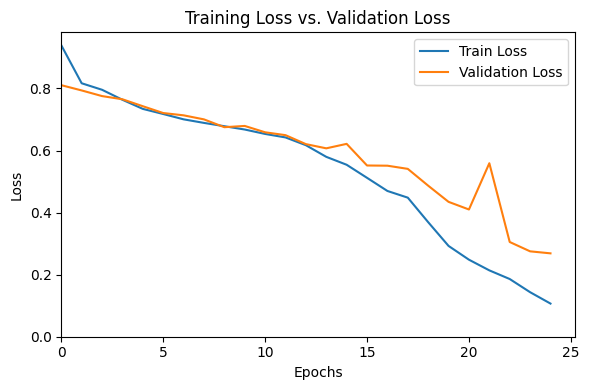

In [31]:
# # View model losses
# plot_losses(model_fit)  # Function to plot the training and validation losses over epochs, from unet.ipynb

### Step 14: Optionally Load a Saved Model

In this step, we can optionally load a previously saved model. This is useful if we have a model that we would like to train on a new set of data, if our training was previously interrupted, or if we'd like to test a model on a new data set. Recall from [Step 10](#step-10-configure-and-build-the-u-net-model) we used custom metrics and saved them to a dictionary `custom_objects`. Because we used custom metrics, we must include that dictionary when loading our model. Tensorflow does not save custom objects (in our case only custom metrics, but you can also define custom callbacks, custom optimizers, etc.) when saving the model, but becasue they are referenced in the model, they must be defined when loading the model. 

In [32]:
# Optional loading of a model
# NOTE: If you have used custom metrics, you must explicitly load them back in with the model.
LOAD_MODEL = True  # Flag to indicate whether to load a pre-trained model
if LOAD_MODEL:
    model = tf.keras.models.load_model(
        model_path,                    # Path to the saved model
        custom_objects=custom_objects  # Custom objects (e.g., custom metrics) to load with the model
    )

### Step 15: Test the Trained Model

In this step we can test how our model performs on our test data set generated in [Step 9](#step-9-split-the-data). 

We first ensure that our model is fixed, so that it will not update by setting `model.trainable = False`.
We can use the number of classes printed out in [Step 8](#step-8-preprocess-the-data), to assign `class_labels` if we'd like, to use in the figures of the masks. Similarly we can specify the color map to use when displaying the masks. The color maps come from the `matplotlib` library and can be found [here](https://matplotlib.org/stable/users/explain/colors/colormaps.html).

We then call the custom function `test_unet`. This is defined in [`unet.ipynb`](unet.ipynb) and additional details can be found there or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024). We feed in the model, the test images and masks, and the number of classes. 

We have set the optional settings such as:
- `threshold`: The threshold to use on binary data when separating it into foreground and background. The default is 0.5, and it is an output of the `preprocess_images_and_masks` in [Step 8](#step-8-preprocess-the-data), as a precaution, since in the preprocessing, as previously discussed, we may convert multi-class masks to binary masks where appropriate. 
- `image_names`: The names of the images to display. We set this value in [Step 9](#step-9-split-the-data).
- `display_count`: The number of predicted masks to display. Because the figure displays the image, the true mask, and the predicted mask, you should keep this value relatively small to avoid clutter. 
- `class_labels`: The labels for the classes. Note that if this is incorrect, the values will be overriden with just the class index.
- `class_color_map`: the color map that we specified using the `matplotlib` library's color maps. 

The `test_unet` function will output Precision, Recall, and F1 Scores for each class, or single values in the binary mask classes case. These three metrics are defined in  [`unet.ipynb`](unet.ipynb) but are included here for clarity as well:
- Precision: Calculates the precision, which is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of the accuracy of the positive predictions.

    $$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$

- Recall: Calculates the recall, also known as sensitivity or true positive rate, which is the ratio of correctly predicted positive observations to all the actual positives. It is a measure of how well the model can capture positive instances.

    $$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$

- F1 Score: Calculates the F1 score, which is the weighted average of precision and recall. It considers both false positives and false negatives and is useful when you need a balance between precision and recall. Note that F1 score is also known as the Dice Coefficient.

    $$ \text{F1 Score} = 2 \frac{(\text{Precision}) (\text{Recall})}{\text{Precision} + \text{Recall}} $$

- TP - True Positive
- FP - False Positive
- FN - False Negative

4/4 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step
Metrics based on test data:

Class Background Individual Metrics:
Precision: 0.9426613817206748
Recall: 0.985878972673488
F1 Score: 0.9637859352771472

Class Low to Medium Risk Individual Metrics:
Precision: 0.9312926481881815
Recall: 0.6022547524607343
F1 Score: 0.7314745185779615

Class High Risk Individual Metrics:
Precision: 0.8538940867915403
Recall: 0.6915834066503561
F1 Score: 0.7642155695800046

Class  Very High Risk Individual Metrics:
Precision: 0.8249081706775518
Recall: 0.7919611270007538
F1 Score: 0.8080989668861962

Class Extreme Risk Individual Metrics:
Precision: 0.8717536095838362
Recall: 0.8256824412290822
F1 Score: 0.8480928022787438



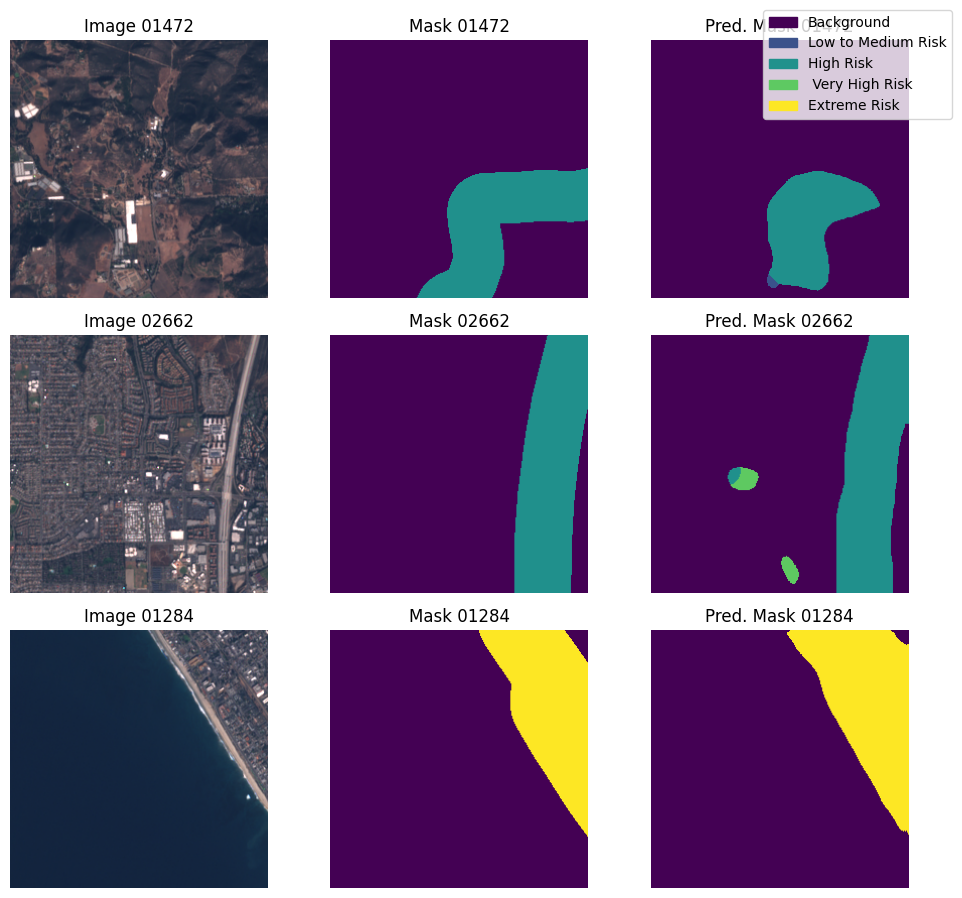

In [33]:
# Ensure that the model won't change now that it has finished training
model.trainable = False

# Define class labels for segmentation
class_labels = {0: "Background", 1: "Low to Medium Risk", 2: "High Risk", 3: " Very High Risk", 4: "Extreme Risk"}

# Define the color map for visualizing the segmentation masks
class_color_map = "viridis"

# Test the model using the test_unet function from `unet.ipynb`
predicted_masks = test_unet(
    model,                           # The trained U-Net model
    images_test,                     # Test images
    masks_test,                      # Ground truth masks for the test images
    num_classes,                     # Number of classes in the segmentation task
    threshold=threshold,             # Threshold for binarizing the predicted masks
    image_names=names_test,          # Names of the test images
    display_count=3,                 # Number of test results to display
    class_labels=class_labels,       # Dictionary mapping class indices to names
    class_color_map=class_color_map  # Colormap for visualizing the masks
)

### Prediction Results

From the example run, we can see that the model performed quite well in predicting the threat risks. **These results demonstrate the practical value and real-world applicability of a U-Net model for segmenting wildfire threats near critical transportation infrastructure.** With high F1-scores across key threat levels, especially very high (0.81) and extreme (0.85), **the model shows that it can detect the most hazardous areas, making it an effective tool for emergency planning and infrastructure risk assessment.** The background class achieved an F1-score of 0.96, indicating the model is highly effective at distinguishing fire-affected areas from non-threat regions.

Additional performance across remaining threat levels also shows meaningful predictive power. Despite slightly lower recall scores for High Risk and Low-to-Medium Risk, the model still achieved F1-scores of 0.73 and 0.76 respectively. **This indicates reasonable performance for more subtle or less spatially distinct fire zones.**

### Importance of Risk Predictions for Transportation Corridors

Predictions indicating the level and location of risk for transportation corridors are highly valuable for emergency management and planning. These predictions enable emergency response teams to:

- Quickly identify transportation corridors at risk or already impacted.
- Rapidly determine the need for rerouting.
- Inform post-fire recovery priorities for repairs and hazard mitigation.

In an era of increasing fire frequency and intensity, compounded by climate-driven weather extremes, models like this are essential tools for building safer, more resilient communities.

### Step 16: Optionally Save the Predicted Masks
In this step, we have included the option to save the predicted masks as images in the users format of choice, though preferably `tif` or `png`. 

The `save_predicted_masks` is a custom function whose details can be found in [`unet.ipynb`](unet.ipynb) or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).

We have set the optional settings such as:
- `mask_names`: the names of the test masks which we generated in [Step 9](#step-9-split-the-data).
- `file_ext`: the file extension (or format) we would like to save the predicted masks in. The default is `tif`

In [34]:
# Save the predicted masks
SAVE_PREDICTED_MASKS = True  # Flag to indicate whether to save the predicted masks
predicted_masks_dir = Path(f"{model_dir}/predicted_masks/")  # Directory to save the predicted masks to as a Path object

if SAVE_PREDICTED_MASKS:
    save_predicted_masks(
        predicted_masks,            # Predicted masks to be saved
        predicted_masks_dir,        # Directory to save the predicted masks
        mask_names=names_test,      # Names of the test images corresponding to the predicted masks
        file_ext="tif"              # File extension for the saved masks
    )

Data saved in models\predicted_masks.


### Step 17: Optionally Save Addtional Files

In this step, we have included the option to copy files from an existing folder, to another folder. The primary intended use is in the cases of `.tif` masks which have an associated `.tfw` file that contains necessary geospatial information. We may want to connect the geospatial information to the predicted masks. Since this data does not change with the prediction, we can copy the existing files to the folder where the predicted masks were saved. This function can similarly be used to save a subset of the images or masks with the predicted masks.  

The `save_associated_files` is a custom function whose details can be found in [`utils.ipynb`](utils.ipynb) or [here](https://github.com/cna-iguide/iGuide_SpatialAI_2024).

We have set the optional settings such as:
- `file_ext`: the file extension (or format) of the files we would like to copy. The default is `tfw`.
- `file_names`: the names of the files we would like to copy. This can be either the trimmed file names (in which case `names_map` should also be provided), or the untrimmed file names.
- `names_map`: the mapping between the original file names and the trimmed file names. This is output by the `load_images_and_masks` function in [Step 5](#step-5-load-the-images-and-masks). 

Note: If `file_names` is not provided, then all files of the given `file_ext` from the original folder will be copied.

In [35]:
# Save files associated with the predicted masks, or other files of interest.
save_associated_files(
    masks_dir,               # Directory containing the original masks
    predicted_masks_dir,     # Directory to save the associated files
    file_ext="tfw",          # File extension of the associated files to be saved
    file_names=names_test,   # Names of the test images corresponding to the associated files
    names_map=names_map      # Mapping of original file names to trimmed names
)

Files saved to models\predicted_masks.


### Comparison with CAL FIRE Classes

We are able to compare the predicted mask results with the class labels from the original CAL FIRE class map, on the Sentinel-2 satellite images. From the images below we can see that the model performs quite well.

<div style="display: flex; justify-content: space-around; margin-bottom: 20px;">
  <figure id="00245GIS" style="margin: 0 10px;">
    <img src="resources/00245_Og.PNG"
    alt="1250X946 png visual of GIS layers used for labeling showing mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>00245 Labels</figcaption>
  </figure>
  <figure id="00245PRED" style="margin: 0 10px;">
    <img src="resources/00245_Pred.PNG"
    alt="1250X946 png visual of the UNet models predicted mask showing mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>00245 Prediction Overlay</figcaption>
  </figure>
</div>

<div style="display: flex; justify-content: space-around; margin-bottom: 20px;">
  <figure id="01000GIS" style="margin: 0 10px;">
    <img src="resources/01000_Og.PNG"
    alt="1250X946 png visual of GIS layers used for labeling showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>01000 Labels</figcaption>
  </figure>
  <figure id="01000PRED" style="margin: 0 10px;">
    <img src="resources/01000_Pred.PNG"
    alt="1250X946 png visual of the UNet models predicted mask showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>01000 Prediction Overlay</figcaption>
  </figure>
</div>

<div style="display: flex; justify-content: space-around; margin-bottom: 20px;">
  <figure id="01205GIS" style="margin: 0 10px;">
    <img src="resources/01205_Og.PNG"
    alt="1250X946 png visual of GIS layers used for labeling showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>01205 Labels</figcaption>
  </figure>
  <figure id="01205PRED" style="margin: 0 10px;">
    <img src="resources/01205_Pred.PNG"
    alt="1250X946 png visual of the UNet models predicted mask showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>01205 Prediction Overlay</figcaption>
  </figure>
</div>

<div style="display: flex; justify-content: space-around; margin-bottom: 20px;">
  <figure id="05125GIS" style="margin: 0 10px;">
    <img src="resources/05125_Og.PNG"
    alt="1250X946 png visual of GIS layers used for labeling showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>05125 Labels</figcaption>
  </figure>
  <figure id="05125PRED" style="margin: 0 10px;">
    <img src="resources/05125_Pred.PNG"
    alt="1250X946 png visual of the UNet models predicted mask showing another mountain road with extreme fire risk classification"
    width="300"/>
    <figcaption>05125 Prediction Overlay</figcaption>
  </figure>
</div>


## Conclusions

Overall, these results suggest that the model is especially effective at identifying severe threat areas, which are typically the most critical for emergency planning and infrastructure protection. The slightly lower recall for lower-risk zones may reflect visual ambiguity in moderate threat areas, which is common in wildfire segmentation tasks.

Unlike static wildfire risk layers, which are region-specific and not updated in real time, **our model offers a repeatable and adaptable approach that can be applied anywhere similar data is available**. This makes it especially valuable in areas without detailed risk assessments or where land use and vegetation have changed due to development or natural disasters. Since the model was trained exclusively on California data, a future improvement will be to fine-tune the model for applicability to other fire-prone regions such as Oregon, Texas, or Australia.

Our work provides a pretrained model that can be reused with new imagery inputs, enabling assessments after wildfire events or in proactive planning efforts. Its flexibility and ease of integration make it a powerful asset for transportation planners, emergency response coordinators, and GIS specialists. The outputs can be incorporated into both open-source and proprietary GIS platforms for analysis, visualization, and operational use.

All additional relevant documentation for model use, interoperability, and guidance on preparing new inputs or training datasets is available in the U-Net Pretrained Model and U-Net GIS Data elements hosted on the I-GUIDE platform. 

**By focusing on the intersection of wildfire risk and infrastructure vulnerability, this work contributes a novel, timely, and actionable approach to wildfire mapping—one that’s increasingly critical as extreme weather events intensify.**

## References

### References used in this notebook

<a id="hubel-wiesel-1959"></a>[Hubel, D. H., & Wiesel, T. N. (1959)](https://doi.org/10.1113/jphysiol.1959.sp006308) Receptive fields of single neurones in the cat's striate cortex. *Journal of Physiology*, 148(3), 574-591. https://doi.org/10.1113/jphysiol.1959.sp006308

<a id="yamaguchi-et-al-1990"></a>[Yamaguchi, K., Sakamoto, K., Akabane, T., & Fujimoto, Y. (1990)] A neural network for speaker-independent isolated word recognition," In *ICSLP-1990*, 1077-1080.

<a id="oh-jung-2004"></a>[Oh, K.-S., & Jung, K. (2004)](https://doi.org/10.1016/j.patcog.2004.01.013) Oh, K.-S., & Jung, K. (2004). GPU implementation of neural networks. Pattern Recognition, 37(6), 1311-1314. https://doi.org/10.1016/j.patcog.2004.01.013

<a id="deng-2022"></a>[Deng, T. (2022)](https://doi.org/10.1109/BDICN55575.2022.00145) Deng, T. (2022). A survey of convolutional neural networks for image classification: Models and datasets. In 2022 International Conference on Big Data, Information and Computer Network (BDICN) (pp. 746-749). https://doi.org/10.1109/BDICN55575.2022.00145

<a id="ronneberger-et-al-2015"></a>[Ronneberger, O., Fischer, P., & Brox, T. (2015)](https://arxiv.org/abs/1505.04597) Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional networks for biomedical image segmentation. https://arxiv.org/abs/1505.04597

<a id="zijdenbos-et-al-1994"></a>[Zijdenbos, A. P., Dawant, B. M., Margolin, R. A., & Palmer, A. C. (1994)](https://doi.org/10.1109/42.363096) Zijdenbos, A. P., Dawant, B. M., Margolin, R. A., & Palmer, A. C. (1994). Morphometric analysis of white matter lesions in MR images: method and validation. IEEE Transactions on Medical Imaging, 13(4), 716-724. https://doi.org/10.1109/42.363096

<a id="taha-hanbury-2015"></a>[Taha, A. A., & Hanbury, A. (2015)](https://doi.org/10.1186/s12880-015-0068-x) Taha, A. A., & Hanbury, A. (2015). Metrics for evaluating 3D medical image segmentation: analysis, selection, and tool. BMC Medical Imaging, 15, 29. https://doi.org/10.1186/s12880-015-0068-x

<a id="muller-et-al-2022"></a>[Müller, D., Soto-Rey, I., & Kramer, F. (2022)](https://doi.org/10.1186/s13104-022-06096-y) Müller, D., Soto-Rey, I., & Kramer, F. (2022). Towards a guideline for evaluation metrics in medical image segmentation. BMC Research Notes, 15, 210. https://doi.org/10.1186/s13104-022-06096-y

<a id="atas-2023"></a>[Ataş, İ. (2023)](https://doi.org/10.17694/bajece.1212563) Ataş, İ. (2023). Performance Evaluation of Jaccard-Dice Coefficient on Building Segmentation from High Resolution Satellite Images. Balkan Journal of Electrical and Computer Engineering, 11(1), 100-106. https://doi.org/10.17694/bajece.1212563

<a id="eelbode-et-al-2020"></a>[Eelbode, T., et al. (2020)](https://doi.org/10.1109/TMI.2020.3002417) Eelbode, T., et al. (2020). Optimization for Medical Image Segmentation: Theory and Practice When Evaluating With Dice Score or Jaccard Index. IEEE Transactions on Medical Imaging, 39(11), 3679-3690. https://doi.org/10.1109/TMI.2020.3002417

### Additional references
<a id="asce-2025"></a>[American Society of Civil Engineers. (2025, January 15)](https://www.asce.org/publications-and-news/civil-engineering-source/article/2025/01/15/as-wildfires-rage-in-la-area-infrastructure-including-roadways-under-threat) American Society of Civil Engineers. (2025, January 15). As wildfires rage in L.A. area, infrastructure — including roadways — under threat. Civil Engineering Source. https://www.asce.org/publications-and-news/civil-engineering-source/article/2025/01/15/as-wildfires-rage-in-la-area-infrastructure-including-roadways-under-threat

<a id="cal-fire-2023"></a>[CAL FIRE. (2023)](https://frap.fire.ca.gov/mapping/gis-data) CAL FIRE. (2023). Wildland Fire Threat GIS Layer. California Department of Forestry and Fire Protection. https://frap.fire.ca.gov/mapping/gis-data

<a id="chester-li-2020"></a>[Chester, M. V., & Li, R. (2020)](https://escholarship.org/uc/item/60d0k700) Chester, M. V., & Li, R. (2020). Vulnerability of California roadways to post-wildfire debris flow. University of California Institute of Transportation Studies. https://escholarship.org/uc/item/60d0k700

<a id="esa-2015"></a>[European Space Agency (ESA). (2015)](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) "European Space Agency (ESA). (2015). Sentinel-2 User Handbook. Copernicus Programme. https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi

<a id="matthew-et-al-2025"></a>[Matthew, C., Ebony, H. G., Kevin, H., Srinivas, H., & Tatyana, H. (2025)](https://www.singletonschreiber.com/theblog/the-largest-wildfires-in-u-s-history) Matthew, C., Ebony, H. G., Kevin, H., Srinivas, H., & Tatyana, H. (2025). The Largest, Deadliest, and Costliest Wildfires in U.S. History. Singleton Schreiber. https://www.singletonschreiber.com/theblog/the-largest-wildfires-in-u-s-history

<a id="resilient-infrastructure-nd"></a>[Resilient Infrastructure. (n.d.)](https://wildfires.resilientinfrastructure.org/) "Resilient Infrastructure. (n.d.) Wildfires and infrastructure. Retrieved April 5, 2025. https://wildfires.resilientinfrastructure.org/

<a id="shukl-2024"></a>[Shukl, S. (2024)](https://www.kaggle.com/code/satyaprakashshukl/road-segmentation-using-unet-model) "Shukl, S. (2024). Road segmentation using U-Net model [Notebook]. Kaggle. https://www.kaggle.com/code/satyaprakashshukl/road-segmentation-using-unet-model

<a id="us-census-2019"></a>[U.S. Census Bureau. (2019)](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-california-primary-and-secondary-roads-state-based-shapefile) "U.S. Census Bureau. (2019). TIGER/Line shapefile, 2019, state, California, primary and secondary roads, state-based shapefile. Data.gov. https://catalog.data.gov/dataset/tiger-line-shapefile-2019-state-california-primary-and-secondary-roads-state-based-shapefile

<a id="us-dot-bts-2025"></a>[U.S. Department of Transportation, Bureau of Transportation Statistics. (2025)](https://geodata.bts.gov/datasets/usdot::north-american-rail-network-lines/about) "U.S. Department of Transportation, Bureau of Transportation Statistics. (2025). North American Rail Network Lines [Data set]. Federal Railroad Administration. https://geodata.bts.gov/datasets/usdot::north-american-rail-network-lines/about

<a id="vincent-2025"></a>[Vincent, R. (2025)](https://www.latimes.com/business/story/2025-01-24/estimated-cost-of-fire-damage-balloons-to-more-than-250-billion) Vincent, R. (2025). Estimated cost of fire damage balloons to more than $250 billion. Los Angeles Times. https://www.latimes.com/business/story/2025-01-24/estimated-cost-of-fire-damage-balloons-to-more-than-250-billion